# Bonus1: Parallel Algorithms (Decentralized Optimization)

### Name: Harman Singh Bath


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.03333134 -0.00899833  0.07757726  0.0988063   0.001419    0.0548428
   0.0095346   0.01509145]]
test std = 
[[1.06805005 1.03258155 0.86336279 0.98452403 0.91739704 1.14284902
  0.98057207 0.91956871]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# 2. Worker

Definine a Worker Class

In [28]:
import numpy

# Class defining a worker node
class Worker:
    def __init__(self, node_name, x, y, alpha, beta, lam, weight_factor):
        self.node_name = node_name
        self.neighbors=[]
        self.x = x # s x d local feature matrix
        self.y = y # s x 1 local label matrix
        self.s = x.shape[0] # number of local samples
        self.d = x.shape[1] # number of features
        self.weight_factor = weight_factor
        self.lam = lam
        self.v = numpy.zeros((self.d,1)) # d x 1
        self.alpha = alpha
        self.beta = beta
        
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(self.s)
        self.x = self.x[rand_indices, :]
        self.y = self.y[rand_indices, :]
        
        self.w = numpy.zeros((self.d,1)) # d x 1 model parameter vector
        
    # add neighbors
    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)
    
    # set model parameters to latest
    def set_param(self, w):
        self.w = w
        
    # compute local loss
    def loss(self):
        yx = numpy.multiply(self.y, self.x) # s x d
        yxw = numpy.dot(yx, self.w) # s x 1
        vec1 = numpy.exp(-yxw) # s x 1
        vec2 = numpy.log(1+vec1) # s x 1
        return numpy.sum(vec2)
        
    # compute local gradient
    def gradient(self, y, x):
        yx = numpy.multiply(y, x) # s x d
        yxw = numpy.dot(yx, self.w) # s x 1
        vec1 = numpy.exp(yxw) # s x 1
        vec2 = numpy.divide(yx, 1+vec1) # s x d
        g = -numpy.sum(vec2, axis=0).reshape(self.d, 1) # d x 1
        return g
    
    def agd(self, g):
        self.v *= self.beta
        self.v += g
        self.w -= self.alpha*self.v
        
    def objective(self, lam, loss):
        reg = lam/2 * numpy.sum(self.w*self.w)
        self.obj = loss/self.s + reg
        return self.obj
        
    def client_update(self):
        g = self.gradient(self.y, self.x)

        for neighbor in self.neighbors:
            scaled_weights = self.weight_factor * neighbor.w
            self.w = self.w + scaled_weights
        self.w /= 1 + ( self.weight_factor * len(self.neighbors) )
        self.agd(g)
        local_loss =self.loss()
        return self.w, local_loss

# 3. Simulation Generator

In [29]:
import math

def create_workers(m,x,y,alpha,beta,lam,weight_factor):
    n,d = x.shape
    s = math.floor(n/m)
    
    workers = []
    for i in range(m):
        indices = list(range(i * s, (i+1) * s))
        workers.append(Worker("worker_"+str(i+1), x[indices,:], y[indices,:], alpha, beta, lam, scale_factor))
    return workers

### 3.1. Gradient Descent with equal weights for all neighbors

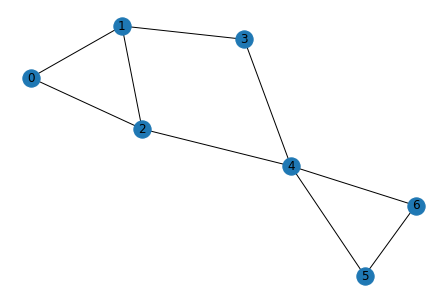

In [30]:
import networkx as nx

m = 7 # number of worker nodes
weight_factor = 1
alpha = 1E-4
beta = 0.99
lam = 1E-4

workers = create_workers(m, x_train, y_train, alpha, beta, lam, weight_factor)

g = nx.Graph() 
# assign neighbors
workers[0].add_neighbor(workers[1])
g.add_edge(0,1)
workers[0].add_neighbor(workers[2])
g.add_edge(0,2)
workers[1].add_neighbor(workers[0])
g.add_edge(1,0)
workers[1].add_neighbor(workers[2])
g.add_edge(1,2)
workers[1].add_neighbor(workers[3])
g.add_edge(1,3)
workers[2].add_neighbor(workers[0])
g.add_edge(2,0)
workers[2].add_neighbor(workers[1])
g.add_edge(2,1)
workers[2].add_neighbor(workers[4])
g.add_edge(2,4)
workers[3].add_neighbor(workers[1])
g.add_edge(3,1)
workers[3].add_neighbor(workers[4])
g.add_edge(3,4)
workers[4].add_neighbor(workers[2])
g.add_edge(4,2)
workers[4].add_neighbor(workers[3])
g.add_edge(4,3)
workers[4].add_neighbor(workers[5])
g.add_edge(4,5)
workers[4].add_neighbor(workers[6])
g.add_edge(4,6)
workers[5].add_neighbor(workers[4])
g.add_edge(5,4)
workers[5].add_neighbor(workers[6])
g.add_edge(5,6)
workers[6].add_neighbor(workers[4])
g.add_edge(6,4)
workers[6].add_neighbor(workers[5])
g.add_edge(6,5)

nx.draw(g, with_labels = True)

In [32]:
# Execute Federated Averaging
max_epoch = 500

objvals_100 =[]
for t in range(max_epoch):
    weights=[]
    losses=[]
    for i in range(m):
        w, local_loss = workers[i].client_update()
        weights.append(w)
        losses.append(local_loss)
    w, loss = aggregate(weights, losses)
    obj = objective(lam, w, loss, x_train.shape[0])
    objvals_100.append(obj)
    print("Objective function value = " + str(obj))
 

Objective function value = 0.44907243779396844
Objective function value = 0.449061592579314
Objective function value = 0.4490489812721189
Objective function value = 0.44903461741435513
Objective function value = 0.4490185341315637
Objective function value = 0.4490007839378503
Objective function value = 0.44898143831166687
Objective function value = 0.4489605870483802
Objective function value = 0.44893833739849404
Objective function value = 0.4489148130031027
Objective function value = 0.4488901526406632
Objective function value = 0.4488645088014659
Objective function value = 0.4488380461082292
Objective function value = 0.4488109396030044
Objective function value = 0.4487833729220649
Objective function value = 0.4487555363816258
Objective function value = 0.4487276249981003
Objective function value = 0.448699836467143
Objective function value = 0.4486723691259477
Objective function value = 0.4486454199231684
Objective function value = 0.44861918242042087
Objective function value = 0.44

Objective function value = 0.4484307391586212
Objective function value = 0.44842978982074017
Objective function value = 0.448428579484772
Objective function value = 0.4484271234615124
Objective function value = 0.4484254381846858
Objective function value = 0.44842354097330206
Objective function value = 0.448421449791209
Objective function value = 0.44841918300747136
Objective function value = 0.4484167591610876
Objective function value = 0.44841419673337635
Objective function value = 0.44841151393114326
Objective function value = 0.4484087284834739
Objective function value = 0.44840585745469236
Objective function value = 0.4484029170756915
Objective function value = 0.44839992259548195
Objective function value = 0.4483968881544206
Objective function value = 0.44839382668019695
Objective function value = 0.4483907498072485
Objective function value = 0.44838766781988754
Objective function value = 0.44838458961902894
Objective function value = 0.448381522712033
Objective function value = 

Objective function value = 0.4482174544109545
Objective function value = 0.4482180128353672
Objective function value = 0.4482186261590544
Objective function value = 0.44821929138898225
Objective function value = 0.448220005486407
Objective function value = 0.44822076538229916
Objective function value = 0.44822156799256235
Objective function value = 0.4482224102328922
Objective function value = 0.4482232890331278
Objective function value = 0.44822420135095314
Objective function value = 0.4482251441848225
Objective function value = 0.44822611458598427
Objective function value = 0.44822710966950047
Objective function value = 0.4482281266241676
Objective function value = 0.4482291627212647
Objective function value = 0.4482302153220628
Objective function value = 0.44823128188405853
Objective function value = 0.4482323599659006
Objective function value = 0.4482334472310023
Objective function value = 0.44823454144984903
Objective function value = 0.4482356405010235
Objective function value = 